##  <b>Plant Seedling Classification using CNNs -  Ike Imala

### **Project Summary:**

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.




### **Objective:**

The aim of this project is to **Build a Convolutional Neural Netowork to classify plant seedlings into their respective categories.**


### **Data Description:**
The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are Labels.csv.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet



### Importing necessary libraries

In [ ]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# Display images using OpenCV
from google.colab.patches import cv2_imshow

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Mounting drive

### Read the dataset

In [ ]:
# Loading a .npy image file
images = np.load('/content/images.npy')

# Read the labels file of dataset
labels = pd.read_csv('/content/Labels.csv')

### Data Overview

- Check the shape of images and the labels in the data
- Converting images from BGR to RGB

#### Checking the shape of the dataset

In [ ]:
# Checking the shape of the image and label data
print(images.shape)

# Displaying the shape of the labels dataset
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


### Observations

- There are 4750 images in the dataset of image resolution 128 x 128 with 3 channels.
- The image in the case would be the X variables while the label are the Y (target labels). For clarity both variables will be splitted into training and test dataset prior to modeling.**

### Plotting images using OpenCV and matplotlib

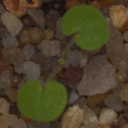

In [ ]:
cv2_imshow(images[5])

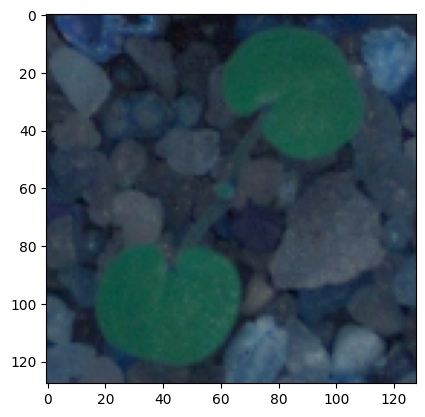

In [ ]:
plt.imshow(images[5])


- Since the images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV.
- As result we will convert these BGR images to RGB images so we could interpret them easily.

#### Converting the BGR images to RGB images.

In [ ]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [ ]:
def plot_images(images,labels):
  num_classes=10
  categories=np.unique(labels)
  keys=dict(labels['Label'])
  rows = 3
  cols = 4
  fig = plt.figure(figsize=(10, 8))
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)
          ax.imshow(images[random_index, :])
          ax.set_title(keys[random_index])
  plt.show()

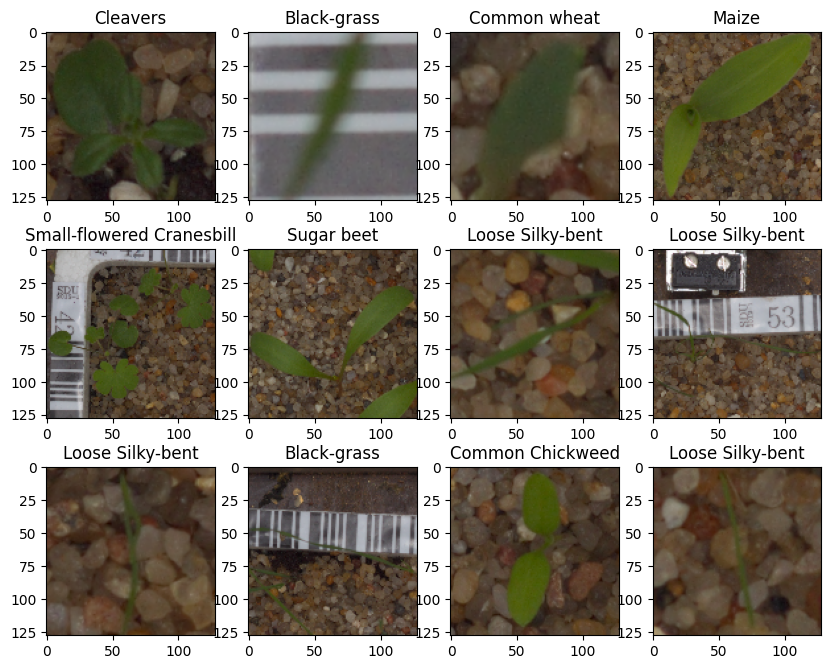

In [ ]:
plot_images(images,labels)


### Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.

<b> Checking for data imbalance

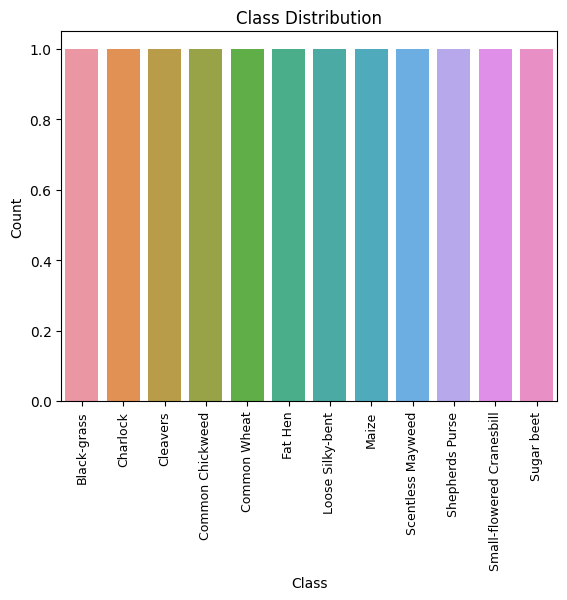

In [ ]:
# Define list of class labels
class_labels = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common Wheat', 'Fat Hen', 'Loose Silky-bent',
                 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

# Convert the list of class labels into a DataFrame
df = pd.DataFrame({'Seed_label': class_labels})

# Using sns.countplot() to plot the class distribution
sns.countplot(data=df, x='Seed_label')

plt.xlabel('Class')
plt.xticks(rotation='vertical', fontsize=9)
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

- We observe that the dataset appears to be quite balanced, with each category having approximately the same number of images.

- So accuracy should be a good evaluation metric for the model performance in this case

### Resizing images
- Here it will be a good idea to resize the image from 128 to 64 to reduce computational runtime as this could be expensive to train.

In [ ]:
# Defining a new height and weight for resizing the image
def resize_image(image, new_width, new_height):
    desired_size = (new_width, new_height)
    resized_image = cv2.resize(image, desired_size)
    return resized_image


new_width = 64
new_height = 64


resized_dataset = []
for image in images:
    resized_image = resize_image(image, new_width, new_height)
    resized_dataset.append(resized_image)

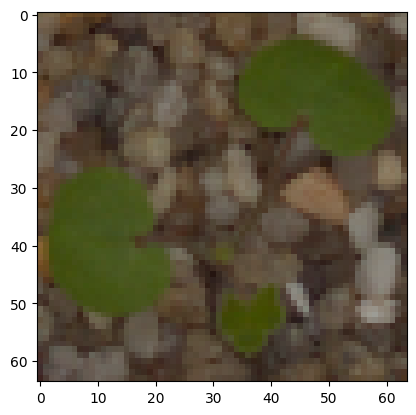

In [ ]:
# Plot resized image
plt.imshow(resized_dataset[7])

### Data Preparation for modeling

- Before proceeding to build a model, we will split the data into train, test, and validation to be able to evaluate the model that we build on the train data
- We need to encode categorical features and scale the pixel values.
- Build a model using the train data and then check its performance

#### Splitting the dataset

**Here We are using the train_test_split() function from scikit-learn.**
  **we split the dataset into three parts, train,test and validation**
**We will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.**

In [ ]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(resized_dataset),labels , test_size= 0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [ ]:
# Check for the shape of train, validation and test data
print(X_temp.shape,y_train.shape)
print(X_val.shape,y_temp.shape)
print(X_test.shape,y_test.shape)


(4275, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (4275, 1)
(475, 64, 64, 3) (475, 1)


#### Encoding the target labels

- Using LabelBinarizer similar to onehotencoding, however this converts labels from name to onehot vectors.

In [ ]:
# Initializing LabelBinarizer for the y_train, y_val, y_test target labels
from sklearn.preprocessing import LabelBinarizer
# Creating an instance of LabelBinarizer
enc = LabelBinarizer()
# Fit the LabelBinarizer on the target labels
enc.fit(y_train)

LabelBinarizer()

In [ ]:
# Tranform the labels of your training, validation and test data using the initialized encoder
y_train_encoded = enc.transform(y_train)
y_val_encoded   = enc.transform(y_val)
y_test_encoded  = enc.transform(y_test)

In [ ]:
# Checking the shape of encoded target labels for (training, validation and test dataset)
y_train_encoded.shape, y_val_encoded.shape,y_test_encoded.shape

((3847, 12), (428, 12), (475, 12))

#### Data Normalization (Scaling)

In neural networks, it is always suggested to **normalize the feature inputs**. Normalization has the below benefits while training a neural networks model:

1. **Normalization makes the training faster and reduces the chances of getting stuck at local optima.**
2. In deep neural networks, **normalization helps to avoid exploding gradient problems.** Gradient exploding problem occurs when large error gradients accumulate and result in very large updates to neural network model weights during training. This makes a model unstable and unable to learn from the training data.

- Since the image pixel values range from 0-255, our method of normalization here will be scaling by dividing all the pixel values by 255 to standardize the images to have values between 0-1.

In [ ]:
# Normalize the image pixels of train, test and validation data
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

### Model Building - Convolutional Neural Network (CNN)


First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's **set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow** to be able to reproduce the same results every time we run the code.



#### Clearing the backend session and initializing the random seed values

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

**Building a CNN Model with the following 2 main parts -**

**The Feature Extraction layers which are comprised of convolutional and pooling layers.
The Fully Connected classification layers for prediction**


We will also compile and train the model using the train data. Here, we are using the loss function - categorical_crossentropy as this is a multi-class classification problem.

We will try to minimize this loss at every iteration using the optimizer Adam. Also, we are choosing accuracy as the metric to measure the performance of the model.

### Model Buidling (CNN)

In [ ]:
# Intializing a sequential model
model_1 = Sequential()

# First convolution layer with 128 filters and kernel size 3x3, padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model_1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# First convolutional layer adding Max pooling to reduce the size of the output
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

# Second Convolution layer with 64 filters and max-pooling layers activation = relu
model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

# Third Convolution layer with 64 filters and max-pooling layers activation = relu
model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

# 1D Flatten of output of the convolution layer after max pooling as input to the fully connected neural network
model_1.add(Flatten())

# ANN architecture with dense layer of 16 neurons
model_1.add(Dense(16, activation='relu'))
model_1.add(Dropout(0.3))
# Output layer with 12 neurons
model_1.add(Dense(12, activation='softmax'))


# Applying the Adam Optimizer
opt=Adam()
# Compile the model with appropriate metric for minimizing the loss function
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])




Let's compile and train the model using the train data. Here, we are using the loss function - categorical_crossentropy as this is a multi-class classification problem. We will try to minimize this loss at every iteration using the optimizer of our choice. Also, we are choosing accuracy as the metric to measure the performance of the model.

#### Summary of the model

In [ ]:
# Generating the summary of the model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

As we can see from the above summary, this CNN model will train and learn **128,828 parameters (weights and biases).**

#### Fitting the model on the train data


In [ ]:
history_1 = model_1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 15s - loss: 2.4545 - accuracy: 0.1063 - val_loss: 2.4377 - val_accuracy: 0.1379 - 15s/epoch - 124ms/step
Epoch 2/30
121/121 - 1s - loss: 2.3620 - accuracy: 0.1791 - val_loss: 2.2003 - val_accuracy: 0.3388 - 1s/epoch - 9ms/step
Epoch 3/30
121/121 - 1s - loss: 2.0518 - accuracy: 0.3213 - val_loss: 1.8359 - val_accuracy: 0.4229 - 1s/epoch - 9ms/step
Epoch 4/30
121/121 - 1s - loss: 1.8679 - accuracy: 0.3689 - val_loss: 1.7077 - val_accuracy: 0.4603 - 1s/epoch - 10ms/step
Epoch 5/30
121/121 - 1s - loss: 1.7507 - accuracy: 0.3891 - val_loss: 1.5488 - val_accuracy: 0.5164 - 1s/epoch - 10ms/step
Epoch 6/30
121/121 - 1s - loss: 1.6310 - accuracy: 0.4247 - val_loss: 1.5198 - val_accuracy: 0.5117 - 1s/epoch - 10ms/step
Epoch 7/30
121/121 - 1s - loss: 1.5786 - accuracy: 0.4432 - val_loss: 1.3691 - val_accuracy: 0.5280 - 1s/epoch - 9ms/step
Epoch 8/30
121/121 - 1s - loss: 1.4919 - accuracy: 0.4749 - val_loss: 1.1811 - val_accuracy: 0.6238 - 1s/epoch - 9ms/step
Epoch 9/30
121/12

#### Model Evaluation

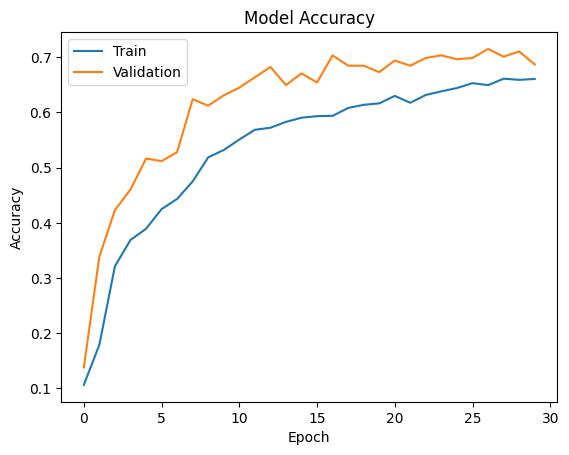

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**

- Looking at the above plot we can observe that the training accuracy is a bit lower than the validation accuracy, although there is not much of overfitting present, we could still try to reduce the gap between  or improve both accuracy

#### Evaluating the model on test data

In [ ]:
model_1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.8935 - accuracy: 0.7116 - 262ms/epoch - 17ms/step


[0.8935102820396423, 0.7115789651870728]

**Observations:**

- We can see that our training accuracy is 66%% and our test accuracy is 71%. The model performance is not too impressive and requires some tunning/regularization.  We will also perform some data augumentation as there is likely presence of overfitting, the model is not well generalized

- Using less convolution layer filters to see if we could improve our performance a little.

#### Plot the Confusion Matrix





*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





In [ ]:
# Here we would get the output as probablities for each category
# Complete the code to predict the output probabilities
y_pred=model_1.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


Converting the target variable into its original form by using the numpy. argmax() function which returns indices of the max element of the array in a particular axis and this original form of target will be used in calculating the accuracy, and plotting the confusion matrix.

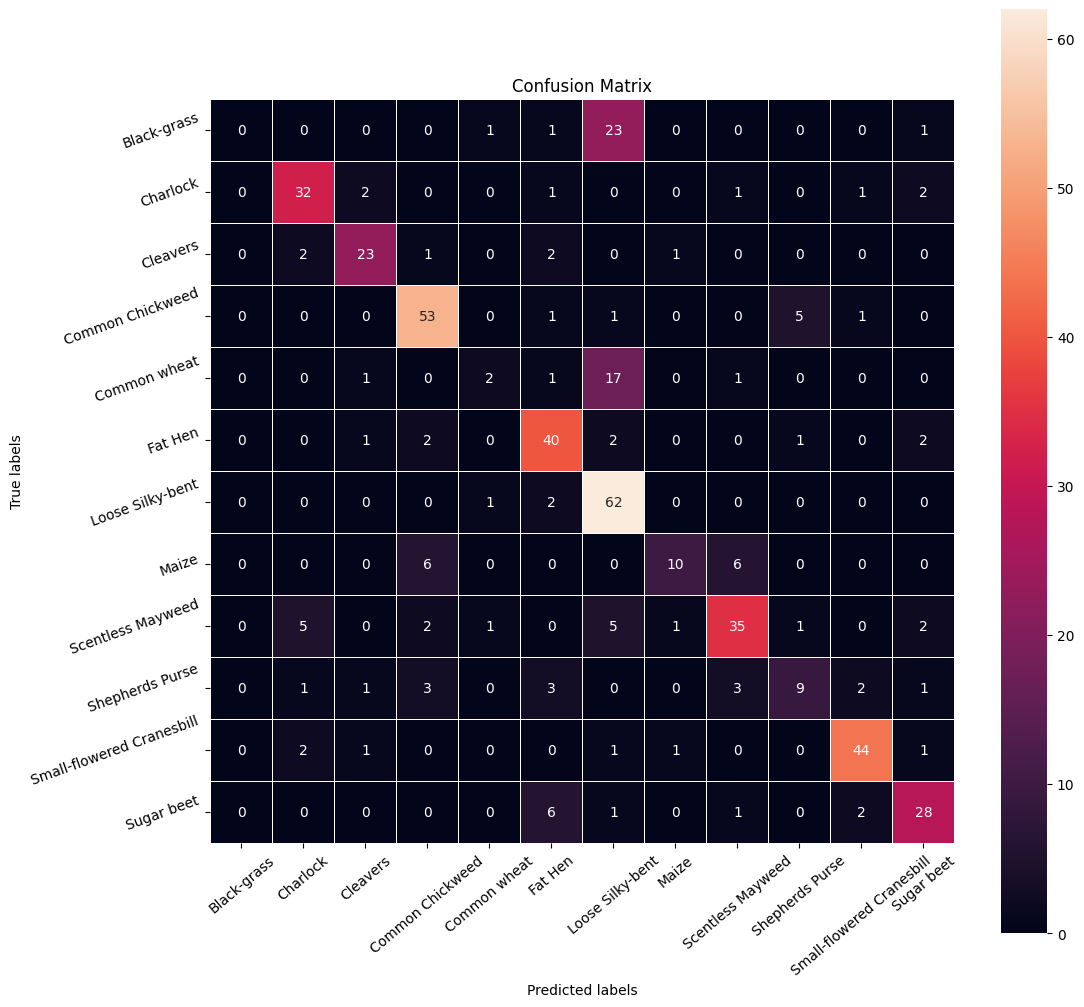

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

**Observations**:
- We plot a confusion matrix to understand if our predictions of plant species are properly classified.
- We can observer that most of the classes are predicted/classified correctly with few exceptions.  For example some charlock class is wrong classified as Scentless Mayweed. Also Loose Silky-bent is worngly classified as Black-grass
- Therfore based on the confusion matrix where there seems to higher number of classification than mis-classification, we think the model is reasonable.  However, we can try model tuning by increase the model raw power by increaseing number of conolution layers and convolution filters to see if we can improve the model and minimize further mis-classification

#### Plot Classification Report





In [ ]:
#importing required functions
from sklearn.metrics import classification_report

#Printing the classification report
print(classification_report(y_test_arg, y_pred_arg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.76      0.82      0.79        39
           2       0.79      0.79      0.79        29
           3       0.79      0.87      0.83        61
           4       0.40      0.09      0.15        22
           5       0.70      0.83      0.76        48
           6       0.55      0.95      0.70        65
           7       0.77      0.45      0.57        22
           8       0.74      0.67      0.71        52
           9       0.56      0.39      0.46        23
          10       0.88      0.88      0.88        50
          11       0.76      0.74      0.75        38

    accuracy                           0.71       475
   macro avg       0.64      0.62      0.62       475
weighted avg       0.68      0.71      0.68       475



### Deleting the model and history variable to use the RAM efficiently

In [ ]:
# Deleting the history_1 variable
del model_1
del history_1

# **Improving the Base Model using Data Augmentation and Regularization**




- Here we will attempt to use data augumentation as a regularization technique to improve our model perfomance.


**Reducing the Learning Rate:**

**ReduceLRonPlateau()** function will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### **Data Augmentation**


**Data augmentation will not be used in the validation/test data set**.

In [ ]:
from keras.callbacks import ReduceLROnPlateau

# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

#### Clearing the backend session and initializing the random seed values

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Applying a simple data augumentation method "rotation" to the data and generating the images
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

### Model- 2

In [ ]:
# Initializing the model
model2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3, padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
# Adding second conv layer with 32 filters and kernel size 3x3, padding 'same'
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
# Adding max pooling to reduce the size of output of second conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))
# Batch nomalization helps with overfitting
model2.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))
# Dropout here helps with overfitting
model2.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

# Using Adam gradient descent optimizer
opt=Adam()
# Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                        

#### Fitting the model on the train data

In [ ]:
# Applying the actual augumentation data on the training data at time of training
# Fitting the model on train data with batch_size=64 and epochs=30
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
60/60 [==============================] - 8s 99ms/step - loss: 2.1373 - accuracy: 0.2440 - val_loss: 2.3989 - val_accuracy: 0.1285 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 4s 67ms/step - loss: 1.6857 - accuracy: 0.3984 - val_loss: 2.2986 - val_accuracy: 0.2991 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 6s 92ms/step - loss: 1.4840 - accuracy: 0.4705 - val_loss: 2.2501 - val_accuracy: 0.2547 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 4s 67ms/step - loss: 1.3994 - accuracy: 0.5025 - val_loss: 2.1630 - val_accuracy: 0.4673 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 5s 91ms/step - loss: 1.2845 - accuracy: 0.5419 - val_loss: 1.8309 - val_accuracy: 0.5023 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 4s 67ms/step - loss: 1.2004 - accuracy: 0.5702 - val_loss: 1.6448 - val_accuracy: 0.6355 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 5s 90ms/step - loss: 1.1

#### Model Evaluation

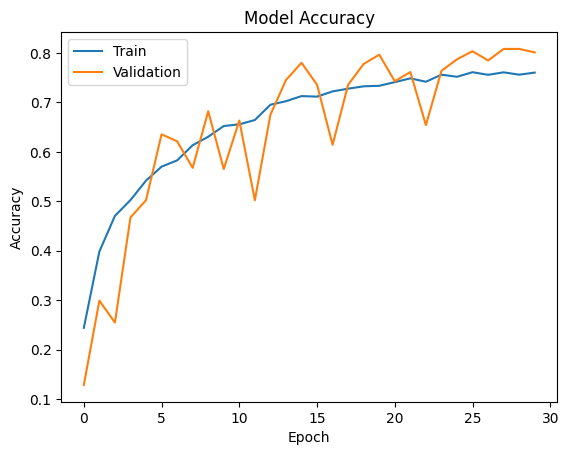

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**

- We can definitely observe that training performance has improved as well as validation performance increased.  However the curve of the validation looks very noisy.
- We can also confirm that the data augumentaion method applied helped the training performance improve, while the batch normalization and droupot must have introduced some noise on the validation accuracy.

#### Evaluating the model on test data

In [ ]:
# Model Evaluation on text data
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.6959 - accuracy: 0.7895 - 169ms/epoch - 11ms/step


**Observations:**

- Evaluating the tunned model on the test data we can see that the test accuracy seems much better with 78% compared to the test accuracy of the base model , however still with jittery, not stable enough. Also the training accuracy 76% and validation accuracy 80% seems pretty good

- Data Augmentation has also helped in improving the model

- To resolve this jittery we will attempt to build a 3rd model and tune on the optimizer by using a lower learning rate or use the same learning rate but add/tunning the decay parameter to achieve a stable valadiation performance.  

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model2.predict(X_test_normalized)

15/15 [==============================] - 0s 2ms/step


#### Plotting the Confusion Matrix

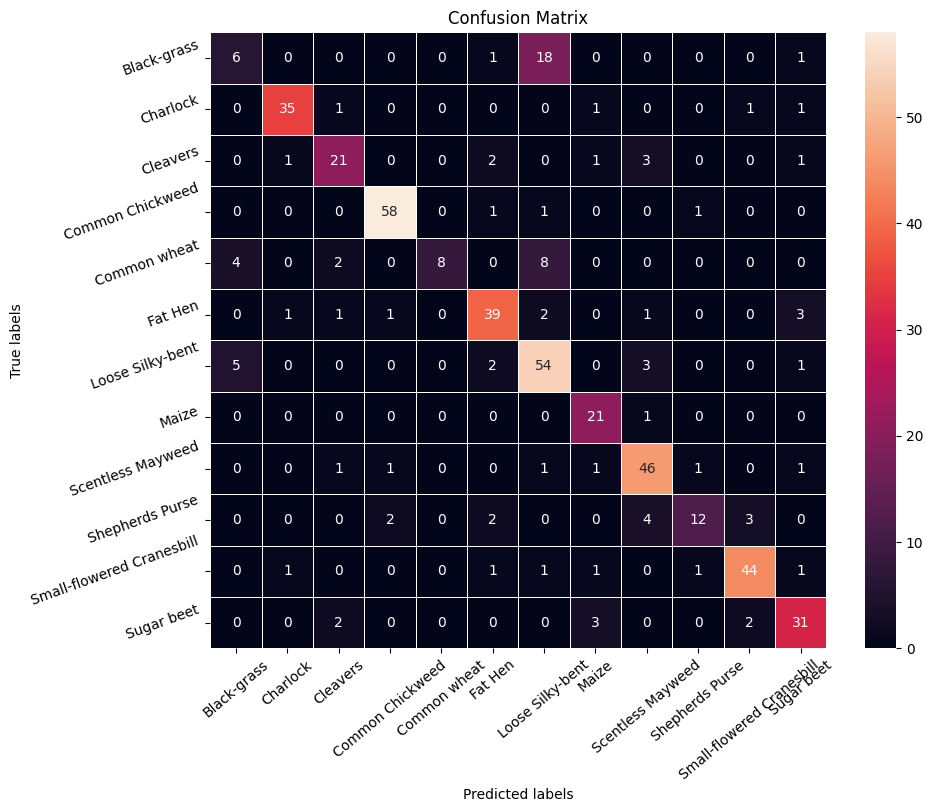

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

**Observation:**
- The confusion matrix appears to be improving compared to the base model, although there are still some mis-classification
- Black-grass as loose silky-bent,
- loose silky-bent mis-classified as Scentless mayweed
- Shepherds purse mis-classified as Scentless mayweed.
- So we can see that the model is not very perfect but a bit better than the base model prediction

#### Plot Classification Report

In [ ]:
#importing required functions
from sklearn.metrics import classification_report

#Printing the classification report
print(classification_report(y_test_arg,y_pred_arg))

              precision    recall  f1-score   support

           0       0.40      0.23      0.29        26
           1       0.92      0.90      0.91        39
           2       0.75      0.72      0.74        29
           3       0.94      0.95      0.94        61
           4       1.00      0.36      0.53        22
           5       0.81      0.81      0.81        48
           6       0.64      0.83      0.72        65
           7       0.75      0.95      0.84        22
           8       0.79      0.88      0.84        52
           9       0.80      0.52      0.63        23
          10       0.88      0.88      0.88        50
          11       0.78      0.82      0.79        38

    accuracy                           0.79       475
   macro avg       0.79      0.74      0.74       475
weighted avg       0.79      0.79      0.78       475



**Observations**:

The model is giving about 79% accuracy on the test data which is comparable to the accuracy of the validation data of 80%. This implies that the model is giving a generalized performance.


### Deleting the model and history variable to use the RAM efficiently


In [ ]:
# Deleting the history_1 variable
del model2
del history

### Model- 3

Let's try to improve the model performance better than the model 2 by adding more convolution layers/filters and also increasing the learning rate and adjusting the decay.  Also we will increase the number of neuron in the fully connected layer

In [ ]:
from keras.callbacks import ReduceLROnPlateau

# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.01,
                                            min_lr=0.000001)

#### Clearing the backend session and initializing the random seed values

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Applying a simple data augumentation method "rotation" to the data and generating the images
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [ ]:
# Initializing the model
model3 = Sequential()

# Adding first conv layer with 128 filters and kernel size 3x3, padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model3.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model3.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
# Adding second conv layer with 64 filters and kernel size 3x3, padding 'same'
model3.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
# Adding max pooling to reduce the size of output of second conv layer
model3.add(MaxPooling2D((2, 2), padding = 'same'))
# Batch nomalization helps with overfitting
model3.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model3.add(Flatten())

# Adding a fully connected dense layer with 32 neurons
model3.add(Dense(32, activation='relu'))
# Dropout here helps with overfitting
model3.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model3.add(Dense(12, activation='softmax'))

# Using Adam gradient descent optimizer
opt=Adam()
# Compile model
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                        

In [ ]:
# Applying the actual augumentation data on the training data at time of training
# Fitting the model on train data with batch_size=64 and epochs=30
# Epochs
epochs = 22
# Batch size
batch_size = 64

history = model3.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/22
60/60 [==============================] - 8s 82ms/step - loss: 1.8509 - accuracy: 0.3561 - val_loss: 2.3486 - val_accuracy: 0.1565 - lr: 0.0010
Epoch 2/22
60/60 [==============================] - 5s 75ms/step - loss: 1.4123 - accuracy: 0.5022 - val_loss: 2.2145 - val_accuracy: 0.3154 - lr: 0.0010
Epoch 3/22
60/60 [==============================] - 5s 83ms/step - loss: 1.2563 - accuracy: 0.5549 - val_loss: 2.1210 - val_accuracy: 0.2734 - lr: 0.0010
Epoch 4/22
60/60 [==============================] - 4s 71ms/step - loss: 1.1147 - accuracy: 0.6122 - val_loss: 1.9693 - val_accuracy: 0.4229 - lr: 0.0010
Epoch 5/22
60/60 [==============================] - 6s 95ms/step - loss: 1.0123 - accuracy: 0.6439 - val_loss: 1.7360 - val_accuracy: 0.4790 - lr: 0.0010
Epoch 6/22
60/60 [==============================] - 4s 71ms/step - loss: 0.9590 - accuracy: 0.6643 - val_loss: 1.4975 - val_accuracy: 0.5444 - lr: 0.0010
Epoch 7/22
60/60 [==============================] - 4s 71ms/step - loss: 0.8

**Observations**:

The model is giving about 82% accuracy on the training data and 81% on the validation data. This implies that the model is giving a generalized performance.


#### Model Evaluation

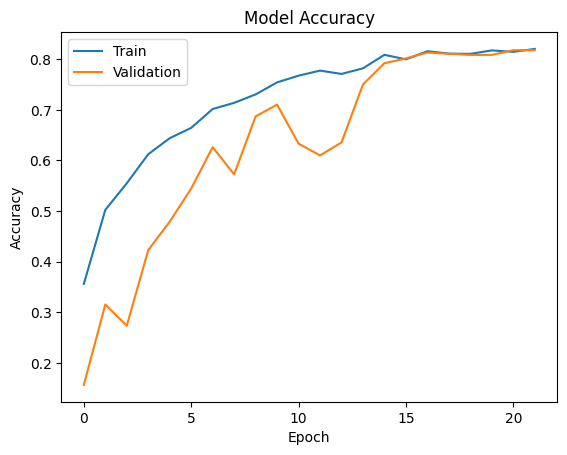

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Model Evaluation on text data
accuracy = model3.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.7298 - accuracy: 0.7726 - 110ms/epoch - 7ms/step


In [ ]:
# Here we would get the output as probablities for each category
y_pred=model3.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


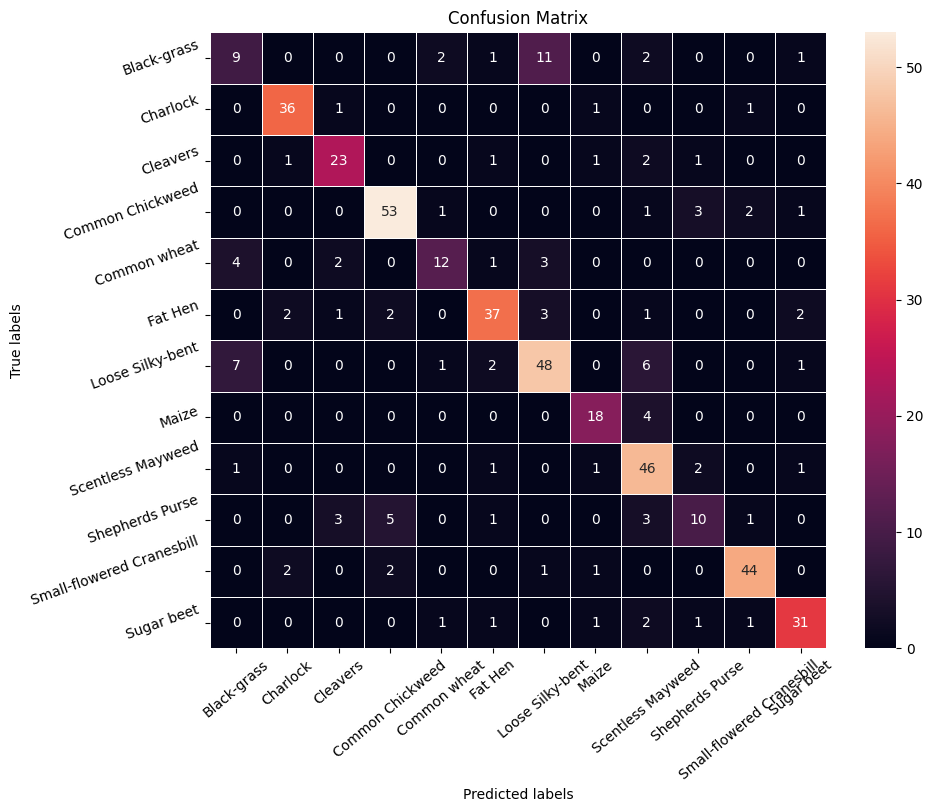

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

- Based on the confusion matrix and accuracy curve, Model 3 has outperformed Model 2. The model is well generalized.
- Thus we can say that model 3 is our best model and we can use this model to predict, which greatly aided in recognizing similar types of plants.
- So, we recommend the company to use Model -3 which has good accuracy to identify different plants.


### Plot Classification Report

In [ ]:
#importing required functions
from sklearn.metrics import classification_report

#Printing the classification report
print(classification_report(y_test_arg,y_pred_arg))

              precision    recall  f1-score   support

           0       0.43      0.35      0.38        26
           1       0.88      0.92      0.90        39
           2       0.77      0.79      0.78        29
           3       0.85      0.87      0.86        61
           4       0.71      0.55      0.62        22
           5       0.82      0.77      0.80        48
           6       0.73      0.74      0.73        65
           7       0.78      0.82      0.80        22
           8       0.69      0.88      0.77        52
           9       0.59      0.43      0.50        23
          10       0.90      0.88      0.89        50
          11       0.84      0.82      0.83        38

    accuracy                           0.77       475
   macro avg       0.75      0.73      0.74       475
weighted avg       0.77      0.77      0.77       475




**Observations**:

The model is giving about 77% accuracy on the test data which is close to the accuracy of the validation data. This implies that the model is giving a generalized performance.

### Visualizing the prediction

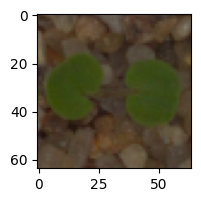

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


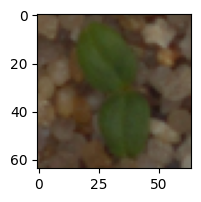

1/1 [==============================] - 0s 21ms/step
Predicted Label ['Cleavers']
True Label Cleavers


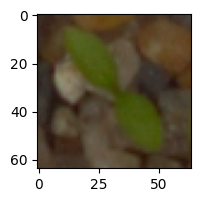

1/1 [==============================] - 0s 26ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


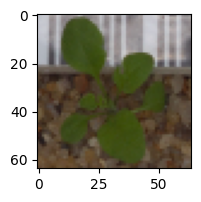

1/1 [==============================] - 0s 31ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model3.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model3.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
print('Predicted Label', enc.inverse_transform(model3.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model3.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector


## Recommendation and Conclusion


Data is stored in two different files.
- Images.npy: This file stores the pixel values of each image in an array format.
- Labels.csv: This file contains the label of each of the images.
- There are 4750 images with an image size of 128x128x3, which belongs to 12 different categories of classes in the target variable, and they are:  **1 Black-grass 2.Charlock 3.Cleavers 4.Common Chickweed 5.Common Wheat 6.Fat Hen 7.Loose Silky-bent 8.Maize 9.Scentless Mayweed 10.Shepherds Purse 11.Small-flowered Cranesbill 12.Sugar beet.**
- Model - 1: This base model was not able to distinguish between the classes and has low precision, recall, and accuracy rate.
- Model - 2: When compared to the previous model, this model was able to distinguish between the classes with good precision, recall, and accuracy rate. This model includes a data augmentation technique, which greatly aided in recognizing similar types of plants.So, we recommend the company to use Model - 2 which has good accuracy to identify different plants.
- The model-3 has a better model performance overall, the train and test model is well generalized compared to the previous models. The model is able to predict better on the test images with lesser mis-classification compared to Base model 1.
- Data Augmentation definitely improved the model performance, however, a more robust covolutional neural network layer with data augumentaion was applied to improve the model further.
- To achieve better model performance increasing the convolution filter helped in obtaining a better model performance. This could help in predicting the test images better.
- The model is able to predict the common chickweed species class much better than the rest species.
- The model might have a bit of difficulty in predicting the black-grass species compared to the rest. Perhaps with additional model tunning one might be able to achieve better model prediction overall.  
- The black-grass and common wheat classes are the most confused classes among all.
- Precision has a high range with the classes species "0,8 & 9" having the least precision.



-
